In [ ]:
!pip install statsmodels --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller


In [3]:
# Upload and read CSV
df = pd.read_csv('/content/data.csv')

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Compute Previous Month's Real Price
df['Prev_Real_Price'] = df['Real Price'].shift(1)

# Calculate Dividend Yield
df['Dividend_Yield'] = df['Real Dividend'] / df['Prev_Real_Price']

# Drop NaNs and 0s for log calculation
df = df[df['Dividend_Yield'].notna() & (df['Dividend_Yield'] > 0)]

# Log of Dividend Yield
df['Log_Dividend_Yield'] = np.log(df['Dividend_Yield'])

# Display first few rows to verify
df[['Date', 'Dividend_Yield', 'Log_Dividend_Yield']].head()


,Date,Dividend_Yield,Log_Dividend_Yield
9,1871-01-01,0.058964,-2.830832
1,1871-02-01,0.054577,-2.908134
2,1871-03-01,0.056970,-2.865236
3,1871-04-01,0.058557,-2.837749
4,1871-05-01,0.056084,-2.880896


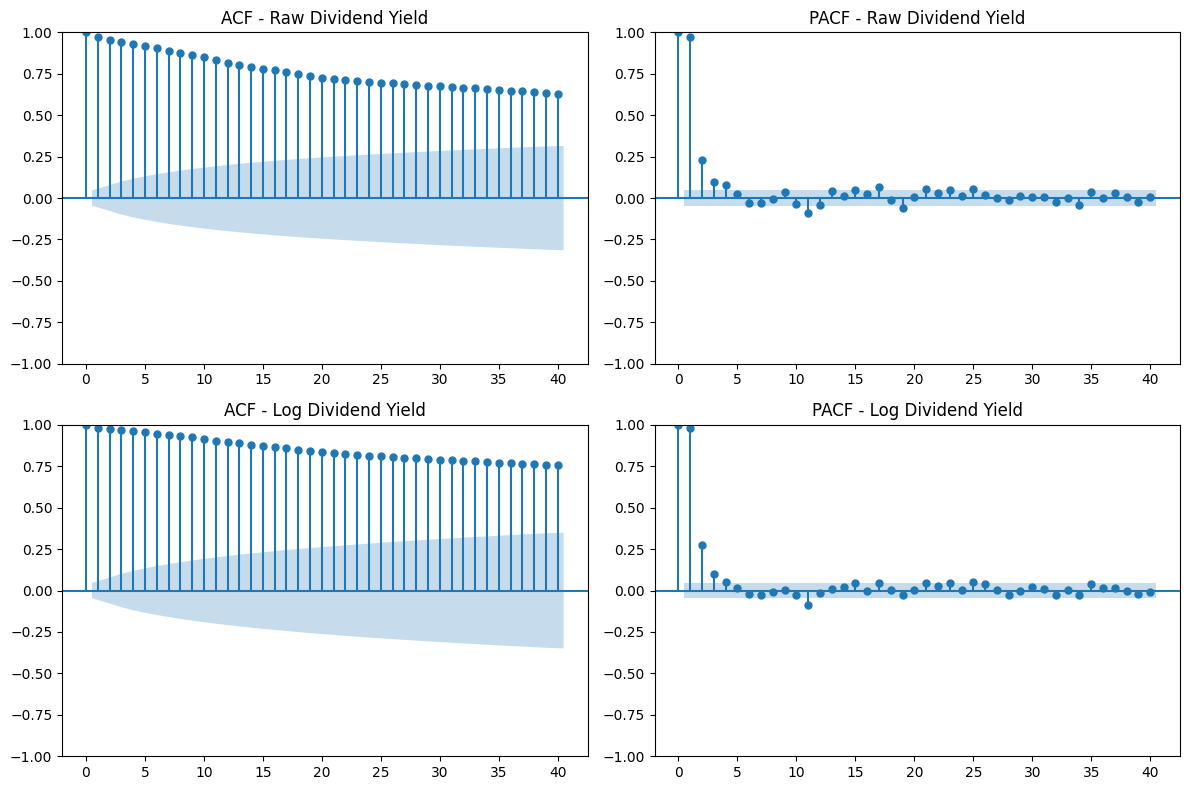

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(df['Dividend_Yield'], lags=40, ax=axes[0, 0])
axes[0, 0].set_title("ACF - Raw Dividend Yield")

plot_pacf(df['Dividend_Yield'], lags=40, ax=axes[0, 1])
axes[0, 1].set_title("PACF - Raw Dividend Yield")

plot_acf(df['Log_Dividend_Yield'], lags=40, ax=axes[1, 0])
axes[1, 0].set_title("ACF - Log Dividend Yield")

plot_pacf(df['Log_Dividend_Yield'], lags=40, ax=axes[1, 1])
axes[1, 1].set_title("PACF - Log Dividend Yield")

plt.tight_layout()
plt.show()


In [9]:
# Plot Comparison: ACF & PACF for Monthly Dividend Yield

#1. ACF (Autocorrelation Function)
# Raw & Log Series:

# Slowly decaying ACF with very high autocorrelation at lag 1 and gradually decreasing values beyond that.

# This is a classic indicator of non-stationarity — specifically a unit root or persistent trend.

# The similarity between raw and log ACF curves confirms that log transformation had little impact.

# 2.PACF (Partial Autocorrelation Function)
# Raw & Log Series:

# PACF shows a strong spike at lag 1, and smaller spikes at lag 2 (and possibly 3).

# After that, PACF values drop closer to zero.

# This structure suggests:

# Possible AR(1) or AR(2) behavior,

# Once differenced, the series may become stationary and suitable for ARIMA modeling.




In [7]:
# Why Log and Raw Series Look Similar
# Log transformation has minimal impact on values that are already small and positive (like the Dividend_Yield values, which are around 0.05–0.06).

# Since the range of values is narrow, log(x) behaves nearly linearly — so the correlation structure (ACF/PACF) is preserved.

# Hence, both the raw and log series are non-stationary and exhibit strong autocorrelation (slowly decaying ACF, significant PACF spikes).

# Interpretation of Plots
# ACF:
# Both raw and log series show strong persistence (high values) — the ACF tails off slowly, indicating non-stationarity (likely a trend or unit root).

# PACF:
# Both show significant spikes at lags 1–2, suggesting short-term dependency that might be captured by an AR(1) or AR(2) process after differencing.



In [6]:
print("Box-Ljung Test (lag=5):")
for col in ['Dividend_Yield', 'Log_Dividend_Yield']:
    result = acorr_ljungbox(df[col], lags=[5], return_df=True)
    stat = result['lb_stat'].iloc[0]
    pval = result['lb_pvalue'].iloc[0]
    print(f"{col}: Statistic = {stat:.4f}, p-value = {pval:.4f}")

print("\n Augmented Dickey-Fuller (ADF) Test:")
for col in ['Dividend_Yield', 'Log_Dividend_Yield']:
    adf_result = adfuller(df[col])
    stat = adf_result[0]
    pval = adf_result[1]
    print(f"{col}: ADF Statistic = {stat:.4f}, p-value = {pval:.4f}")


Box-Ljung Test (lag=5):
Dividend_Yield: Statistic = 8133.1721, p-value = 0.0000
Log_Dividend_Yield: Statistic = 8592.5017, p-value = 0.0000

 Augmented Dickey-Fuller (ADF) Test:
Dividend_Yield: ADF Statistic = -2.4718, p-value = 0.1225
Log_Dividend_Yield: ADF Statistic = -1.3980, p-value = 0.5832


In [10]:
# Interpretation:

# The null hypothesis of the Box-Ljung test is that the data are independently distributed (i.e., no autocorrelation).

# Since p-values < 0.05, we reject the null hypothesis for both raw and log series.

# Conclusion: Significant autocorrelation exists in both series → the data are not white noise.



In [11]:
# Interpretation:

# The null hypothesis of the ADF test is that the series has a unit root (i.e., non-stationary).

# Since p-values > 0.05, we fail to reject the null hypothesis for both series.

# Conclusion: Both raw and log Dividend Yield series are non-stationary.



In [ ]:
# Final Conclusion-
# 1. Autocorrelation is present (Box-Ljung Test).

# 2.Both series are non-stationary (ADF Test).

# 3.Log transformation does not induce stationarity, as ACF/PACF and ADF test show similar results.



